NLP sentiment analysis of IMDB reviews dataset using a LSTM recurrent neural network, licensed under the [Apache License, Version 2.0](http://www.apache.org/licenses/LICENSE-2.0)

# Table of contents
* [Main libraries](#libraries)
* [IMDB dataset](#IMDB)
* [Data preprocessing](#preprocessing)
* [Data splitting and tokenization](#splitting)
* [LSTM Model](#LSTM)
* [Result](#result)

<a id='libraries'></a>
# Main libraries
We start by importing the main libraires that we will use:

- the [re](https://docs.python.org/3/library/re.html) module (for regular expression matching operations)
- the [nltk](https://www.nltk.org/) toolkit (for natural language operations)
- the [random](https://docs.python.org/3/library/random.html) module (for random number generation)
- the [numpy](https://numpy.org/) library (for arrays operations)
- the [pandas](https://pandas.pydata.org/) library (for data analysis)
- the [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) module (for statistics)
- the [matplotlib.pyplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html) interface (for MATLAB-like plots)

We also download (if not already done) the stopwords and punkt [data packages](https://www.nltk.org/data.html) from the nltk toolkit.

In [1]:
import re
import nltk
import random
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

#nltk.download('punkt')
#nltk.download('stopwords')

<a id='IMDB'></a>
# IMDB dataset
We retrieve from [Kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download) the csv file "IMDB Dataset.csv" consisting of 50'000 IMDB movies and TV shows reviews with their positive or negative sentiment classification.

In [2]:
# Storing the csv file into a DataFrame "df"

df = pd.read_csv('IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


We print the basic properties of "df". In particular, we we note that there are no null values in the dataset.

df.shape: (50000, 2) 

df.columns: Index(['review', 'sentiment'], dtype='object') 

df.sentiment.value_counts():
positive    25000
negative    25000
Name: sentiment, dtype: int64 



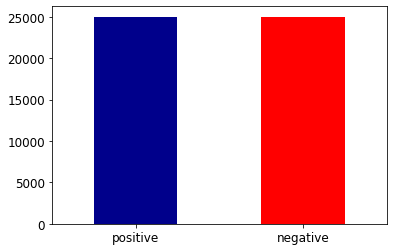

df.info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [3]:
print('\033[1m' + 'df.shape:' + '\033[0m', df.shape, '\n')
print('\033[1m' + 'df.columns:' + '\033[0m', df.columns, '\n')
print('\033[1m' + 'df.sentiment.value_counts():' + '\033[0m')
print(df.sentiment.value_counts(), '\n')

df['sentiment'].value_counts().plot.bar(color=['darkblue', 'r'], rot=0, fontsize='large')
plt.show()

print('\033[1m' + 'df.info:' + '\033[0m')
df.info()

To make the sentiments values suitable for analysis, we convert them to integers:
- positive $\rightarrow$ 1
- negative $\rightarrow$ 0

In [4]:
df.sentiment = [1 if tag == 'positive' else 0 for tag in df.sentiment]
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


<a id='preprocessing'></a>
# Data preprocessing
First, we use regular expressions to make the following transformations to the reviews:

- remove punctuation marks
- remove HTML tags
- remove URL's
- remove characters which are not letters or digits
- remove multiple whitespaces
- convert to lower case
- strip whitespaces from the beginning and the end

In [5]:
# Storing in "before_process" a random example of review before preprocessing
# Defining and applying the function "process" performing the transformations of the reviews
# Storing in "after_process" the example of review after preprocessing

idx = random.randint(0, len(df)-1)
before_process = df.iloc[idx][0]

def process(x):
    x = re.sub('[,\.!?:()"]', '', x)
    x = re.sub('<.*?>', ' ', x)
    x = re.sub('http\S+', ' ', x)
    x = re.sub('[^a-zA-Z0-9]', ' ', x)
    x = re.sub('\s+', ' ', x)
    return x.lower().strip()

df['review'] = df['review'].apply(lambda x: process(x))
after_process = df.iloc[idx][0]

Next, we remove stopwords from the reviews using the [word_tokenize()](https://www.nltk.org/_modules/nltk/tokenize.html#word_tokenize) function from the [nltk.tokenize]((https://www.nltk.org/api/nltk.tokenize.html) package.

In [6]:
# Storing in "sw_set" the set of English stopwords provided by nltk
# Defining and applying the function "sw_remove" which remove stopwords from reviews
# Storing in "after_removal" the example of review after removal of the stopwords

sw_set = set(nltk.corpus.stopwords.words('english'))

def sw_remove(x):
    words = nltk.tokenize.word_tokenize(x)
    filtered_list = [word for word in words if word not in sw_set]
    return ' '.join(filtered_list)

df['review'] = df['review'].apply(lambda x: sw_remove(x))
after_removal = sw_remove(after_process)

For illustration, we print our example of review before preprocessing, after preprocessing and after stopwords removal.

In [7]:
print('\033[1m' + 'Review #%d before preprocessing:' % idx + '\033[0m' + '\n', before_process, '\n')
print('\033[1m' + 'Review #%d after preprocessing:' % idx + '\033[0m' + '\n', after_process, '\n')
print('\033[1m' + 'Review #%d after preprocessing and stopwords removal:' % idx + '\033[0m' + '\n', after_removal)

Review #2232 before preprocessing:
 This film doesn't have a very clear picture of what it is or wants to be. There are some good bits when Stewart is on screen and they give him some lines to work with. It works best early on as romantic comedy, but the story keeps heading for more dramatic territory and gets itself lost in the process. By the last fifteen minutes or so, the plot twists are just a series dramatic clichés. <br /><br />The part with the airplane feels like some leftover footage from another film spliced in.<br /><br />The main reason I can think of to watch it is if you want be able to say you've seen all of Jimmy Stewart's films. 

Review #2232 after preprocessing:
 this film doesn t have a very clear picture of what it is or wants to be there are some good bits when stewart is on screen and they give him some lines to work with it works best early on as romantic comedy but the story keeps heading for more dramatic territory and gets itself lost in the process by the l

<a id='splitting'></a>
# Data splitting and tokenization
We start by splitting our DataFrame into a training and test DataFrames. We use the [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function from the [sklearn.model_selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) module which allow to perform the splitting randomly with respect to the index of the DataFrame.

In [8]:
from sklearn.model_selection import train_test_split

train_rev, test_rev, train_sent, test_sent = train_test_split(df['review'], df['sentiment'], test_size=0.1, random_state=42)

print('\033[1m' + 'train_rev.shape:' + '\033[0m', train_rev.shape)
print('\033[1m' + 'test_rev.shape:' + '\033[0m', test_rev.shape)
print('\033[1m' + 'train_sent.shape:' + '\033[0m', train_sent.shape)
print('\033[1m' + 'test_sent.shape:' + '\033[0m', test_sent.shape)

train_rev.shape: (45000,)
test_rev.shape: (5000,)
train_sent.shape: (45000,)
test_sent.shape: (5000,)


Next, we use the [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) class from [keras.preprocessing.text](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/) module to create a dictionary of the "dict_size" most frequent words present in the reviews (a unique integer is assigned to each word), and we print some of its [attributes](https://faroit.com/keras-docs/1.2.2/preprocessing/text/). The index of the Tokenizer is computed the same way no matter how many most frequent words we use later, see this [post](https://stackoverflow.com/questions/46202519/keras-tokenizer-num-words-doesnt-seem-to-work).

In [9]:
from keras.preprocessing.text import Tokenizer

dict_size = 40000
tokenizer = Tokenizer(num_words=dict_size)
tokenizer.fit_on_texts(df['review'])

print('\033[1m' + 'Number of documents the tokenizer was trained on:' + '\033[0m', tokenizer.document_count, '\n')
print('\033[1m' + 'Length of the tokenizer index:' + '\033[0m', len(tokenizer.word_index), '\n')
print('\033[1m' + 'First 20 entries of the tokenizer index:' + '\033[0m')
print(*list(tokenizer.word_index.items())[:20])

Number of documents the tokenizer was trained on: 50000 

Length of the tokenizer index: 125791 

First 20 entries of the tokenizer index:
('movie', 1) ('film', 2) ('one', 3) ('like', 4) ('good', 5) ('time', 6) ('even', 7) ('would', 8) ('really', 9) ('story', 10) ('see', 11) ('well', 12) ('much', 13) ('get', 14) ('bad', 15) ('people', 16) ('great', 17) ('also', 18) ('first', 19) ('made', 20)


We use the [texts_to_sequences()](https://github.com/keras-team/keras/blob/v2.9.0/keras/preprocessing/text.py#L325-L337) function of the Tokenizer class to convert the training reviews and test reviews to lists of sequences of integers (tokens) "train_rev_tokens" and "test_rev_tokens", and we store in the numpy array "seq_lengths" the lengths of the sequences included in "train_rev_tokens" and "test_rev_tokens".

In [10]:
train_rev_tokens = tokenizer.texts_to_sequences(train_rev)
test_rev_tokens = tokenizer.texts_to_sequences(test_rev)
seq_lengths =  np.array([len(sequence) for sequence in train_rev_tokens + test_rev_tokens])

If the lengths of the sequences were normally distributed, then a given length could be considered small or large when outside the interval

$$
\hbox{mean value of seq_lengths} \pm \hbox{2 standard deviations of seq_lengths,}
$$

and lengths not belonging to this interval would only represent 5% of the elements of seq_lengths (see the [68–95–99.7 rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule) in statistics). Here, we follow this heuristics, and thus define an upper bound for the length of sequences accordingly.

The value of upper_bound is 293 and the percentage of sequence lengths smaller or equal than upper_bound is 94.58%.


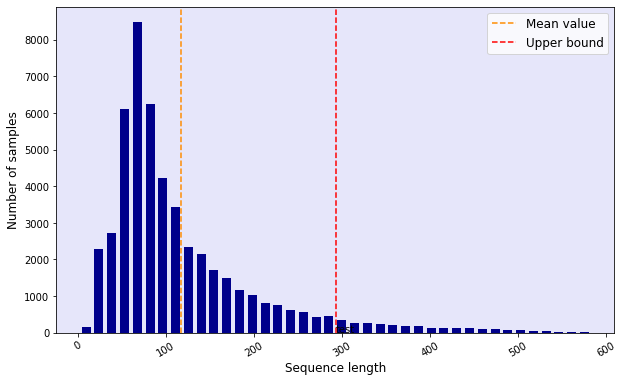

In [11]:
# Storing in "upper_bound" our chosen upper bound for the length of sequences
# Computing the percentage of lengths smaller or equal than "upper_bound"

upper_bound = int(np.mean(seq_lengths) + 2 * np.std(seq_lengths))
percentage = stats.percentileofscore(seq_lengths, upper_bound)

print('The value of upper_bound is %d and the percentage of sequence lengths \
smaller or equal than upper_bound is %.2f%%.' % (upper_bound, round(percentage, 2)))

# Histogram plot of the lengths of the sequences in "train_rev_tokens" and "test_rev_tokens"

_, hist = plt.subplots(figsize=(10,6))
hist.hist(seq_lengths[seq_lengths < 2*upper_bound], color='darkblue', bins=40, rwidth=0.7)
hist.axvline(np.mean(seq_lengths), color='darkorange', linestyle='--', label='Mean value')
hist.axvline(upper_bound, color='r', linestyle='--', label='Upper bound')
hist.set_facecolor('lavender')

# Parameters of the plot

plt.xlabel('Sequence length', size='large')
plt.ylabel('Number of samples', size='large')
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.text(upper_bound, 0, 'test')
plt.legend(fontsize='large')
plt.xticks(rotation=30)
plt.show()

Using the [pad_sequences()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) function from [keras.preprocessing.sequence](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence) module, we transform "train_rev_tokens" and "test_rev_tokens" into 2D numpy arrays of shape (number of sequences, upper_bound). Sequences of length smaller (resp. larger) than "upper_bound" are extended (resp. truncated) to get length equal to "upper_bound".

In [12]:
from keras.preprocessing.sequence import pad_sequences

train_rev_pad = pad_sequences(train_rev_tokens, maxlen=upper_bound)
test_rev_pad = pad_sequences(test_rev_tokens, maxlen=upper_bound)

print('\033[1m' + 'train_rev_pad.shape:' + '\033[0m', train_rev_pad.shape)
print('\033[1m' + 'test_rev_pad.shape:' + '\033[0m', test_rev_pad.shape, '\n')

# Printing an example of review after padding

idx_pad = random.randint(0, len(train_rev_pad)-1)
print('\033[1m' + 'Review #%d after padding:' %idx_pad + '\033[0m' + '\n', train_rev_pad[idx_pad])

train_rev_pad.shape: (45000, 293)
test_rev_pad.shape: (5000, 293) 

Review #10771 after padding:
 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0  

<a id='LSTM'></a>
# LSTM Model
We start by importing some classes from Keras:

- the [Sequential](https://keras.io/api/models/sequential/) class from the keras.models API (to group a linear stack of layers into a model)
- the [Embedding](https://keras.io/api/layers/core_layers/embedding/) class from the keras.layers API (to turn positive integers (indexes) into dense vectors of fixed size)
- the [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/) class from the keras.layers API (to apply a long short-term memory layer to an input)
- the [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) class from the keras.layers API (to apply dropout to the input)
- the [Dense](https://keras.io/api/layers/core_layers/dense/) class from the keras.layers API (to apply a regular densely-connected NN layer to an input)

In [13]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense

In [14]:
# Importing the "imageio.v3" library (for reading and writing images)
# See https://imageio.readthedocs.io/en/stable/

#import imageio.v3 as iio

#image = iio.imread("https://www.tensorflow.org/text/guide/images/embedding2.png")
#plt.figure(figsize = (7, 7))
#plt.imshow(image)
#plt.axis('off');

In [15]:
output_dim = 14
units_lstm = 16
r = 0.8

model = Sequential()
model.add(Embedding(input_dim=dict_size, output_dim=output_dim, input_length=upper_bound))
model.add(LSTM(units_lstm))
model.add(Dropout(r))
model.add(Dense(1, activation='sigmoid'))

We give a summary of the model using the [summary](https://keras.io/api/models/model/#summary-method) method of the [model class](https://keras.io/api/models/model/) of Keras. The "None" value stands for the (not yet defined) value of the batch size.

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 293, 14)           560000    
                                                                 
 lstm (LSTM)                 (None, 16)                1984      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 562,001
Trainable params: 562,001
Non-trainable params: 0
_________________________________________________________________


We import the [plot_model](https://keras.io/api/utils/model_plotting_utils/) function from the [keras.utils.vis_utils](https://faroit.com/keras-docs/2.0.8/visualization/) module to plot a schema of the model.

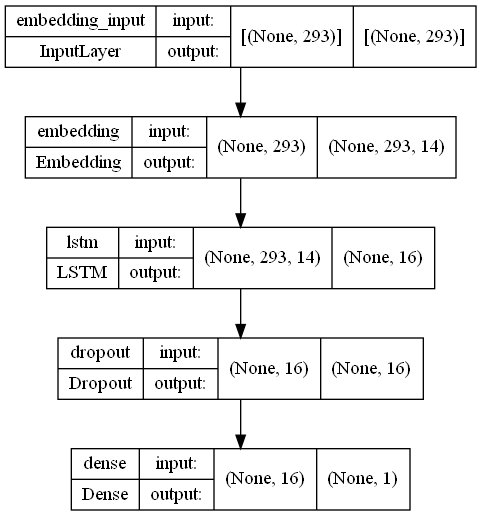

In [17]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True)

We [compile](https://keras.io/api/models/model_training_apis/#compile-method) the model for training with the following parameters:
- [adam](https://keras.io/api/optimizers/adam) as optimizer to use during training process (a combination of gradient descent with momentum and RMSP)
- [binary cross-entropy](https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class) (bce) between true labels and predicted labels as loss to minimise during training process
- [accuracy](https://keras.io/api/metrics/accuracy_metrics/#accuracy-class) as metric to display during training process (how often predicted labels equal true labels)

In [18]:
model.compile(optimizer='adam', loss='bce', metrics='accuracy')

We [train the model](https://keras.io/api/models/model_training_apis/#fit-method) with "train_rev_pad" as input array, "train_sent" as output array, [validation split](https://keras.io/api/models/model_training_apis/#:~:text=validation_split%3A%20Float%20between%200%20and,the%20end%20of%20each%20epoch.), batch size, number of epochs, and the option "shuffle=True" (to shuffle the training data before each epoch). An epoch is a pass of the neural network over the entire training set and the batch size is the number of samples that are passed to the network at once. For each epoch, we thus have

$$
\hbox{number of training steps} = \frac{\hbox{length of training set - length of validation set}}{\hbox{batch size}}\;\!.
$$

In [19]:
validation_split = 0.1
batch_size = 512
epochs = 4

fitted = model.fit(train_rev_pad, train_sent, validation_split=validation_split,
                   batch_size=batch_size, epochs=epochs, shuffle=True)

Epoch 1/4
80/80 [==============================] - 21s 245ms/step - loss: 0.6783 - accuracy: 0.6159 - val_loss: 0.5404 - val_accuracy: 0.7202
Epoch 2/4
80/80 [==============================] - 20s 255ms/step - loss: 0.4672 - accuracy: 0.8312 - val_loss: 0.3762 - val_accuracy: 0.8593
Epoch 3/4
80/80 [==============================] - 18s 226ms/step - loss: 0.3409 - accuracy: 0.8829 - val_loss: 0.2764 - val_accuracy: 0.8929
Epoch 4/4
80/80 [==============================] - 18s 221ms/step - loss: 0.2613 - accuracy: 0.9122 - val_loss: 0.2709 - val_accuracy: 0.8938


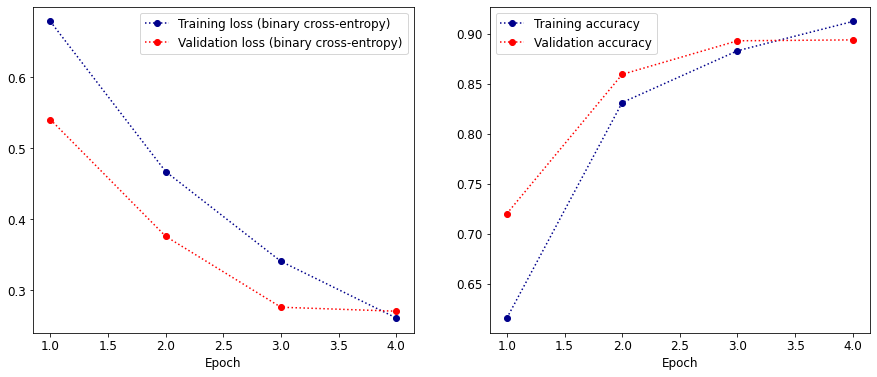

In [20]:
# Storing in "ep_values" the values of the epochs

ep_values = range(1, epochs+1)

# Plot of the training loss and validation loss (binary cross-entropy)

_, (loss, acc) = plt.subplots(1, 2, figsize=(15, 6))

loss.plot(ep_values, fitted.history['loss'], color='darkblue', linestyle='dotted',
            marker='o', label='Training loss (binary cross-entropy)')
loss.plot(ep_values, fitted.history['val_loss'], color='r', linestyle='dotted',
            marker='o', label='Validation loss (binary cross-entropy)')
loss.set_xlabel('Epoch', size='large')
loss.legend(fontsize='large')

acc.plot(ep_values, fitted.history['accuracy'], color='darkblue', linestyle='dotted',
           marker='o', label='Training accuracy')
acc.plot(ep_values, fitted.history['val_accuracy'], color='r', linestyle='dotted',
           marker='o', label='Validation accuracy')
acc.set_xlabel('Epoch', size='large')
acc.legend(fontsize='large')

# Parameters of the plot

plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.show()

<a id='result'></a>
# Result

First, we [evaluate](https://keras.io/api/models/model_training_apis/#evaluate-method) the loss and accuracy of the trained model on the test set.

In [21]:
result= model.evaluate(test_rev_pad, test_sent)

157/157 [==============================] - 2s 14ms/step - loss: 0.2601 - accuracy: 0.8962


Next, we test the trained model on a randomly chosen review from the test set. We display the original review, the sentiment predicted by the model with its probability, and the original (correct) sentiment.

In [22]:
# Storing in DataFrame "df_original" the original reviews and sentiments

df_original = pd.read_csv('IMDB Dataset.csv')

# Choosing randomly a review and its sentiment in the test data

idx_test = random.randint(0, len(test_sent)-1)
idx_original = test_rev.index[idx_test]
(original_rev, original_sent) = df_original.iloc[idx_original]

# Storing in "prediction_sent" the predicted sentiment of the chosen review
# Storing in "probability" the probability of the predicted sentiment of the chosen review

prediction = model.predict(test_rev_pad)[idx_test][0]
prediction_sent = 'positive' if prediction >= 0.5 else 'negative'
probability = round(prediction if prediction >= 0.5 else 1-prediction, 2)

# Printing the original review, its predicted sentiment and probability, and original sentiment

print('\033[1m' + 'Review #%d:' % idx_original + '\033[0m' + '\n', original_rev, '\n')
print('\033[1m' + 'Predicted sentiment:' + '\033[0m', prediction_sent, '(with probability %.2f)' % probability, '\n')
print('\033[1m' + 'Original sentiment:' + '\033[0m', original_sent)

Review #32938:
 This movie is about a young girl who goes to live with her rich cousins falls in love with one of her cousin, and reject the advance of a amoral suitor who brings trouble on the family. After seeing the 1999 version and reading the book, I decided to watch the older version. I found it did stay true to Fanny character in the book, but it was also boring character. Fanny character played by Sylvestra Le Touzel was lackluster; she often appeared to be about to faint. I also did not like Robert Bourbage who played Henry Crawford. I could not imagine him being interested in Fanny or her cousin Maria. Jackie Smith Wood who played Mary Crawford was okay but the wig she wore was so ugly. I lost interested in her acting and I kept staring at her wig. I kept expecting it would drop off her head. I could also see a slip of her real hair under the wig. 

Predicted sentiment: negative (with probability 0.98) 

Original sentiment: negative
